In [30]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import cumtrapz
from sympy.solvers import solve
from scipy.optimize import *
from sympy import *

### Properties and Inputs

In [31]:
#Material Properties - Composite UD Tape
udtape = {
    'Ex': 142e03,   #MPa
    'Ey': 11.2e03,  #MPa
    'Gxy': 5e03,    #MPa
    'vxy': 0.3,     #[-]
    'Xt': 2200,     #MPa
    'Xc': 1800,     #MPa
    'Yt': 70,       #MPa
    'Yc': 300,      #MPa
    'S': 100,       #MPa
    'rho': 1.61e-06 #kg/mm^3
}
lt = 0.135          #mm
#create an array of the properties
udtapeprop = np.array(list(udtape.values()))

#Knockdown Factors 
KF = 0.8 * 0.8 * 0.65
udtapeprop[4:9] = udtapeprop[4:9] * KF
Gc = 0.7 * udtapeprop[2]

In [32]:
#Loads
V   = 1.5e06 #N
M   = 15e09  #Nmm
Dia = 6000   #mm
R = Dia/2

In [33]:
# Fibre properties (Puck), value from Lecture 5, Slide 28, AS4/3501-6
Ef = 225e03 # [MPa] Elastic modulus of the fibre
vf = 0.2 # [-] major Poisson's ratio of the fibre
theta1 = np.array([45, -45, 45, -45, 0, 90, 90, 0, -45, 45, -45, 45, 0, 90])
theta1 = np.concatenate((theta1, theta1[::-1]))
theta1 = np.concatenate((theta1, theta1, theta1))

theta2 = np.array([45, -45, 45, -45, 45, 0, 90, 90, 0, -45, 45, -45, 45, 0, 90])
theta2 = np.concatenate((theta2, theta2[::-1]))
theta2 = np.concatenate((theta2, theta2, theta2))

theta3 = np.array([45, -45, 45, -45, 45, -45, 0, 90, 90, 0, -45, 45, -45, 45, 0, 90])
theta3 = np.concatenate((theta3, theta3[::-1]))
theta3 = np.concatenate((theta3, theta3, theta3))

theta4 = np.array([45, -45, 45, -45, 45, -45, 0, 90, 90, 0, -45, 45, -45, 45, 0, 90, 0])
theta4 = np.concatenate((theta4, theta4[::-1]))
theta4 = np.concatenate((theta4, theta4, theta4))

theta5 = np.array([45, -45, 45, -45, 45, -45, 0, 90, 90, 0, -45, 45, -45, 45, 0, 90, 0, 90])
theta5 = np.concatenate((theta5, theta5[::-1]))
theta5 = np.concatenate((theta5, theta5, theta5))

theta6 = np.array([45, -45, 45, -45, 45, -45, 0, 90, 90, 0, -45, 45, -45, 45, 0, 0, 90, 0, 90])
theta6 = np.concatenate((theta6, theta6[::-1]))
theta6 = np.concatenate((theta6, theta6, theta6))

#Create a matrix of arrays
theta_array = [theta1, theta2, theta3, theta4, theta5, theta6, theta6, theta5, theta4, theta3, theta2, theta1, theta1, theta2, theta3, theta4, theta5, theta6, theta6, theta5, theta4, theta3, theta2, theta1]
zone = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
p1, p2, p3, p4 = 0.3, 0.25, 0.2, 0.25 # [-] 
# Magnigication factor for FF (Puck)
m = 1.1 # (CFRP)
#append the fibre properties to the array
udtapeprop = np.append(udtapeprop, [Ef, vf, p1, p2, p3, p4, m])

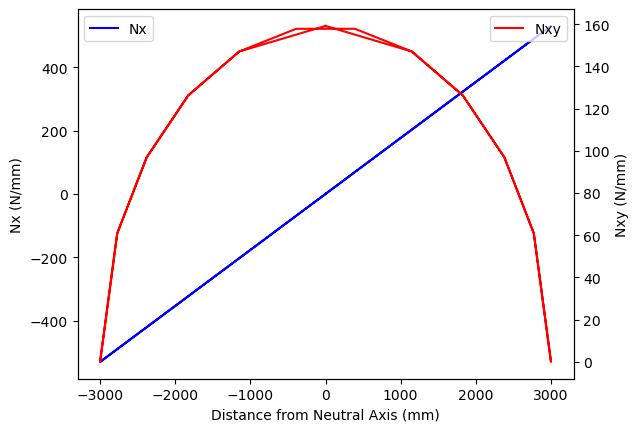

In [34]:
Nx = [] # Inplane loads in material coordinate system
Nxy = []
yloc = [] # Distance of the interval from the neutral axis
loc = [0, 22.5, 37.5, 52.5, 67.5, 90, 90, 112.5, 127.5, 142.5, 157.5, 172.5, 187.5, 202.5, 217.5, 232.5, 247.5, 270, 270, 292.5, 307.5, 322.5, 337.5, 360]#Gives 6 different thickness zones
lll = len(loc)/2
#make lll an integer
lll = int(lll)
for m in loc:
    m = m*np.pi/180
    
    # Bending stress*thickness at every interval
    y = R*np.sin(m)
    I_xx = np.pi*(R**3)
    Nz = M*y/I_xx
    Nx.append(Nz)
    
    # Shear flow at every interval
    qs = V/(np.pi*R)*(np.cos(m))
    Nxy.append(abs(qs))
    
    yloc.append(y)

# Plot Nx and Nxy with respect to yloc on a log scale. plot Nxy on a secondary axis
fig, ax1 = plt.subplots()
ax1.plot(yloc, Nx, 'b-', label='Nx')
ax1.set_xlabel('Distance from Neutral Axis (mm)')
ax1.set_ylabel('Nx (N/mm)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(yloc, Nxy, 'r-', label='Nxy')
ax2.set_ylabel('Nxy (N/mm)')
ax2.legend(loc='upper right')

plt.show()

### Classical Laminate Theory

In [35]:
def calculate_hz(lt, k):
    h = lt * k
    mid_plane = h / 2
    z = np.linspace(-mid_plane, mid_plane, k+1)
    return h, z

In [36]:
def Q_Mat(E1, E2, v12, G12): #On axis Q
    v21 = (v12*E2)/E1
    Qv = 1 - (v12*v21)
    Q11 = E1/Qv
    Q22 = E2/Qv
    Q12 = (v12*E2)/Qv
    Q33 = G12
    QM = np.array([[Q11, Q12, 0], [Q12, Q22, 0], [0, 0, Q33]])
    return QM

In [37]:
def Q_matrix(QM, theta):
    m = np.cos(np.radians(theta))
    n = np.sin(np.radians(theta))
    
    # Calculate individual components of Q matrix
    Qxx = QM[0, 0]*m**4 + QM[1, 1]*n**4 + 2*m**2*n**2*QM[0, 1] + 4*m**2*n**2*QM[2, 2]
    Qxy = QM[0, 0]*m**2*n**2 + QM[1, 1]*m**2*n**2 + QM[0, 1]*(m**4 + n**4) - 4*QM[2, 2]*m**2*n**2
    Qxs = QM[0, 0]*m**3*n - QM[1, 1]*m*n**3 + QM[0, 1]*(m*n**3 - m**3*n) + 2*(m*n**3 - m**3*n)*QM[2, 2]
    Qyy = QM[0, 0]*n**4 + QM[1, 1]*m**4 + 2*m**2*n**2*QM[0, 1] + 4*m**2*n**2*QM[2, 2]
    Qys = QM[0, 0]*m*n**3 - QM[1, 1]*m**3*n + QM[0, 1]*(m**3*n - m*n**3) + 2*(m**3*n - m*n**3)*QM[2, 2]
    Qss = QM[0, 0]*m**2*n**2 + QM[1, 1]*m**2*n**2 - 2*QM[0, 1]*m**2*n**2 + (m**2 - n**2)**2*QM[2, 2]
    
    # Assemble Q matrix
    Qxys = np.array([[Qxx, Qxy, Qxs], [Qxy, Qyy, Qys], [Qxs, Qys, Qss]])
    return Qxys

In [38]:
def ABD(Qxys, z, k):
        
    # Initialize A, B, and D matrices
    A = np.zeros((3, 3))
    B = np.zeros((3, 3))
    D = np.zeros((3, 3))
    
    # Compute A, B, and D matrices
    for i in range(k):
        # A matrix
        A += Qxys[:,:,i]*(z[i+1] - z[i])
        
        # B matrix
        B += (1/2)*(Qxys[:,:,i]*(z[i+1]**2 - z[i]**2))
        
        # D matrix
        D += (1/3)*(Qxys[:,:,i]*(z[i+1]**3 - z[i]**3))
    
    # Assemble ABD matrix
    ABD_matrix = np.block([[A, B], [B, D]])
    return ABD_matrix

### Compute Strain and Stress

In [39]:
def Strain(NM, ABD_matrix):
    # Calculate strains
    inverse_ABD = np.linalg.inv(ABD_matrix)
    strains = np.dot(inverse_ABD, NM)
    return strains

In [40]:
def L_strain(theta, strains, zt):
    strain = strains[:3]
    curv = strains[3:]
    netstrain = strain + zt*curv
    m = np.cos(np.radians(theta))
    n = np.sin(np.radians(theta))
    T = np.array([[m**2, n**2, m*n], [n**2, m**2, -m*n], [-2*m*n, 2*m*n, m**2-n**2]])
    laminastrain = np.dot(T, netstrain)
    return laminastrain

In [41]:
def L_stress(laminastrain, QM):
    laminastress = np.dot(QM, laminastrain)
    return laminastress

### Puck Failure Criteria

In [42]:
def Puck(ud_properties, laminastrain):
    sigma3 = 0 # we assume only in-plane stresses
    sigma1, sigma2, tau21 = laminastrain
    ff_t, ff_c, iff_a, iff_b, iff_c = 0.01, 0.01, 0.01, 0.01, 0.01

    # First get the properties
    E1, E2, G12, v12, Xt, Xc, Yt, Yc, S, rho, Ef, vf, p1, p2, p3, p4, m = ud_properties

    # FF mode (tension & compression) (Eq. 21)
    a = (sigma1-(v12-vf*m*E1/Ef)*(sigma2+sigma3))
    if a >= 0:
        ff_t = 1/Xt*a # tension
    elif a < 0:
        ff_c = -1/Xc*a # compression
    
    # IFF mode A (Eq. 71) sigma2 bigger than or equal to 0
    if sigma2 >= 0:
        iff_a = np.sqrt(((1/Yt - p1/S)*sigma2)**2+(tau21/S)**2)+(p1/S*sigma2)

    # IFF mode B&C
    if tau21 != 0: 
        a = np.abs(sigma2/tau21)
        d = np.abs((Yc/(2*(1+p4)))/(S*np.sqrt(1+2*p4)))
    
        if sigma2 < 0 and a <= d:
            iff_b = np.sqrt((tau21/S)**2+(p2/S*sigma2)**2)+p2/S*sigma2 # IFF mode B&C (Eq. 73)
        elif sigma2 < 0 and a >= d:
            iff_c = ((tau21/(2*(1+p4)*S))**2+(sigma2/Yc)**2)*(-Yc/sigma2) # IFF mode C (Eq. 77)


    return ff_t, ff_c, iff_a, iff_b, iff_c

In [43]:
def miniNx(m, D_11, D_12, D_22, D_66, AR, a):
    Nx_01 = (np.pi/a)**2 * (D_11*m**2 + 2*(D_12+2*D_66)*AR**2 + D_22 * AR**4/m**2)
    return Nx_01

In [44]:
def bucklingNx(ABD_matrix, zone, h, Gc):
    D = ABD_matrix[3:, 3:]
    b = 3000*zone*np.pi/180
    a = 600
    AR = a/b
    D_11 = D[0,0]
    D_12 = D[0,1]
    D_22 = D[1,1]
    D_66 = D[2,2]
    k1 = 5/6
    initial_guess = 1
    bounds = Bounds(1, np.inf)
    result = minimize(miniNx, initial_guess, args=(D_11, D_12, D_22, D_66, AR, a), bounds=bounds)
    m = int(np.round(result.x[0]))
    Nx_01 = (np.pi/a)**2 * (D_11*m**2 + 2*(D_12+2*D_66)*AR**2 + D_22 * AR**4/m**2)
    Nx_02 = Nx_01/(1 + (k1*Nx_01/(h*Gc)))
    return min(Nx_01, Nx_02)

In [45]:
def bucklingNxy(ABD_matrix, zone, h, Gc):
    D = ABD_matrix[3:, 3:]
    b = 3000*zone*np.pi/180
    a = 600
    AR = a/b
    D_11 = D[0,0]
    D_12 = D[0,1]
    D_22 = D[1,1]
    D_66 = D[2,2]
    Nxy_01 = 0.7 * ((9 * np.pi**4 * b) / (32 * a**3)) * (D_11 + (2 * (D_12 + 2 * D_66) * (AR**2)) + (D_22 * (AR**4)))
    Nxy_02 = Nxy_01/(1 + (Nxy_01/(h*Gc)))
    return min(Nxy_01, Nxy_02)

### Results

In [46]:
h_array = []
k_array = []
RFabd = []
N_x_list = []
N_xy_list = []
count = 0
for idx in range(len(loc)):
    theta = theta_array[idx]
    k = len(theta)
    k_array.append(k)
    NM = np.array([[Nx[idx]], [0.], [Nxy[idx]], [0.], [0.], [0.]])
    h, z = calculate_hz(lt, k)
    h_array.append(h)
    QM = Q_Mat(udtapeprop[0], udtapeprop[1], udtapeprop[3], udtapeprop[2])
    Qxys = np.zeros((3, 3, k))
    for i in range(k):
        Qxys[:, :, i] = Q_matrix(QM, theta[i])
    
    ABD_matrix = ABD(Qxys, z, k)


    strains = Strain(NM, ABD_matrix)
    zt = z[:-1]+lt/2
    strain = strains[:3]
    curv = strains[3:]
    netstrain = strain + zt*curv

    laminastrain = np.zeros((3, 1, k))
    laminastress = np.zeros((3, 1, k))
    FI1 = np.zeros((1, 1, k))
    FI2 = np.zeros((1, 1, k))
    FI3 = np.zeros((1, 1, k))
    for i in range(k):
        laminastrain[:, :, i] = L_strain(theta[i], strains, zt[i])
        laminastress[:, :, i] = L_stress(laminastrain[:, :, i], QM)
        
        puck = Puck(udtapeprop, np.reshape(laminastress[:, :, i], (3)))
        FI1[:, :, i] = puck[0] + puck[1]
        FI2[:, :, i] = puck[2]
        FI3[:, :, i] = puck[3] + puck[4]

    FI = np.concatenate((FI1, FI2, FI3), axis=1)
    FI = np.transpose(FI)
    FI = np.reshape(FI, (FI.shape[0], FI.shape[1]))

    max_value = np.max(FI)
    RFabd.append(1/max_value)

    if max_value >= 1:
        count = 1
        #print('Failure Occurs')        

    if idx>=lll:
        N_x_list.append(bucklingNx(ABD_matrix, zone[idx], h, Gc))
        N_xy_list.append(bucklingNxy(ABD_matrix, zone[idx], h, Gc))
        #print('-----------------------')

if count >=1:
    print('Failure Occurs')
else:
    print('No Failure')

print('Minimum RF for combined Nx-Nxy Loading:', np.round(min(RFabd), 2))
print('Minimum Margin of Safety for combined Nx-Nxy Loading:', np.round(min(RFabd)-1, 2))
print('Location of Minimum Margin of Safety for combined Nx-Nxy Loading:', np.argmin(RFabd)+1)
N_x_array = np.array(N_x_list)
N_xy_array = np.array(N_xy_list)
Buckling = ((-1)*((Nx[lll:] / N_x_array))) + ((Nxy[lll:] / N_xy_array)**2)
print('Maximum Buckling Factor:', np.round(max(Buckling),2))
#print location of maximum buckling
print('Location of Maximum BF:', np.argmax(Buckling)+1)

No Failure
Minimum RF for combined Nx-Nxy Loading: 4.44
Minimum Margin of Safety for combined Nx-Nxy Loading: 3.44
Location of Minimum Margin of Safety for combined Nx-Nxy Loading: 5
Maximum Buckling Factor: 0.44
Location of Maximum BF: 5


In [47]:
RF = []
for i in range(len(Buckling)):
    A = (-1)*(Nx[i+lll] / N_x_array[i])
    B = (Nxy[i+lll] / N_xy_array[i])**2
    x = Symbol('x')
    roots = solve(B*x**2 + A*x - 1, real=True)
    RF.append(max(roots))

#Find minimum of RF and round to 2 decimal places
minRF = min(RF)
minRF = round(minRF, 2)
print('Minimum RF for Buckling:', minRF)
print('Minimum Margin of Safety for Buckling:', round(minRF-1, 2))

Minimum RF for Buckling: 2.25
Minimum Margin of Safety for Buckling: 1.25


In [48]:
#Area of a ring of thickness t
Area = np.pi * (R**2 - ((R - np.array(h_array))**2)) * zone / 360
Mass = Area * udtapeprop[9]
print('Mass:', np.round(np.sum(Mass)*1000, 2), 'kg/m')

Mass: 404.68 kg/m


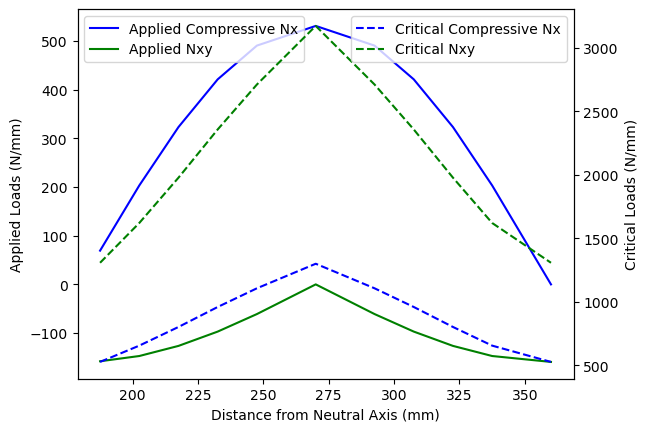

In [49]:
#plot Nx and N_x_list, Nxy and N_xy_list with respect to yloc
Nx = np.array(Nx)
Nx = -Nx
Nxy = np.array(Nxy)
Nxy = -Nxy
fig, ax1 = plt.subplots()
ax1.plot(loc[lll:], Nx[lll:], 'b-', label='Applied Compressive Nx')
ax1.plot(loc[lll:], Nxy[lll:], 'g-', label='Applied Nxy')
ax1.set_xlabel('Distance from Neutral Axis (mm)')
ax1.set_ylabel('Applied Loads (N/mm)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(loc[lll:], N_x_list, 'b--', label='Critical Compressive Nx')
ax2.plot(loc[lll:], N_xy_list, 'g--', label='Critical Nxy')
ax2.set_ylabel('Critical Loads (N/mm)')
ax2.legend(loc='upper right')

plt.show()


In [50]:
#Round h_array to 2 decimal places
h_array = np.round(h_array, 2)
print('Thickness:', max(h_array))

Thickness: 15.39


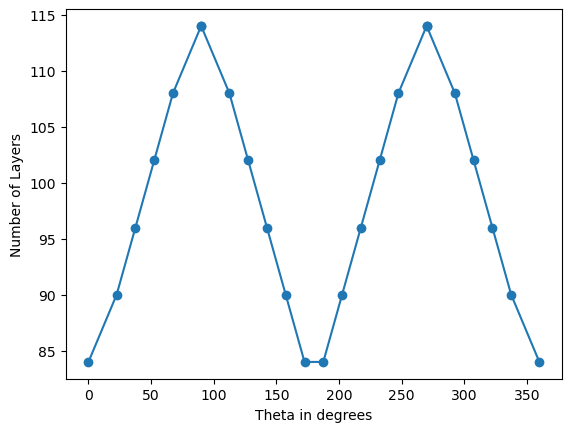

In [53]:
#Plot k_array against loc
plt.plot(loc, k_array, marker='o')
plt.xlabel('Theta in degrees')
plt.ylabel('Number of Layers')
plt.show()

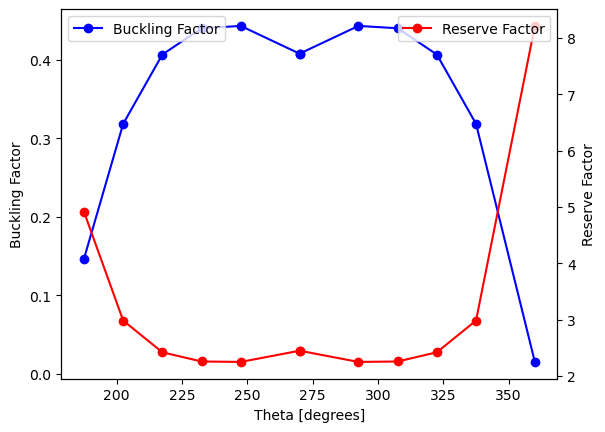

In [52]:

fig, ax1 = plt.subplots()
ax1.plot(loc[lll:], Buckling, 'b-', marker='o', label='Buckling Factor')
ax1.set_xlabel('Theta [degrees]')
ax1.set_ylabel('Buckling Factor')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(loc[lll:], RF, 'r-', marker='o', label='Reserve Factor')
ax2.set_ylabel('Reserve Factor')
ax2.legend(loc='upper right')

plt.show()